Create new T+S initial conditions for a runs with new bathymetry. This should work for both bathy6 and bathy9.

In [36]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import geo_tools  # for nearest point function
from salishsea_tools import nc_tools

%matplotlib inline

# Create TS for bathymetry6

In [27]:
#old bathymetry information
old_path = '../../../NEMO-forcing/grid/bathy_downonegrid2.nc'
old_bathy = nc.Dataset(old_path, 'r')
old_depth = old_bathy.variables['Bathymetry'][:]
old_bathy.close()

(898, 398)


In [34]:
#old initial file (Restart)
initial_path = '/results/SalishSea/nowcast-green/11sep16/SalishSea_00482400_restart.nc'
T_S = nc.Dataset(initial_path, 'r')

#nc_tools.show_variables(T_S)
old_T = T_S.variables['tn'][0] # choose time, tb for a restart file
old_S = T_S.variables['sn'][0] # sb for a restart file
depths = T_S.variables['nav_lev'][:] # nav_lev for a restart file
lon = T_S.variables['nav_lon'][:]
lat = T_S.variables['nav_lat'][:]
print (old_T[:, 427, 292])
print(depths[0:40])
T_S.close()

[ 14.72174908  14.71589708  14.71375057  14.71073139  14.70511032
  14.68187917  14.47915369  14.23865515  12.60603617  11.96262798
  11.87838247  11.71705136  11.48522465  11.43597853  11.32821175
  11.25779775  11.13745004  11.11820731  10.94903978  10.86877365
  10.70368657   0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.        ]
[   0.5000003     1.5000031     2.50001144    3.50003052    4.50007057
    5.50015068    6.50031042    7.50062323    8.50123596    9.50243282
   10.50476551   11.50931168   12.51816654   13.53541183   14.56898212
   15.63428783   16.76117325   18.00713539   19.48178482   21.38997841
   24.10025597   28.22991562   34.68575668   44.51772308   58.48433304
   76.58558655   98.06295776  121.86651611  147.08946228  173.11448669
  199.57304382  226.26029968  253.06663513  279.93453979  306.

In [ ]:
#read in new bathymetry
new_path = '../../../NEMO-forcing/grid/bathy_meter_SalishSea6.nc'
Fraser = nc.Dataset(new_path, 'r')
bathy = Fraser.variables['Bathymetry'][:]
print(bathy.shape)
Fraser.close()

(898, 398)


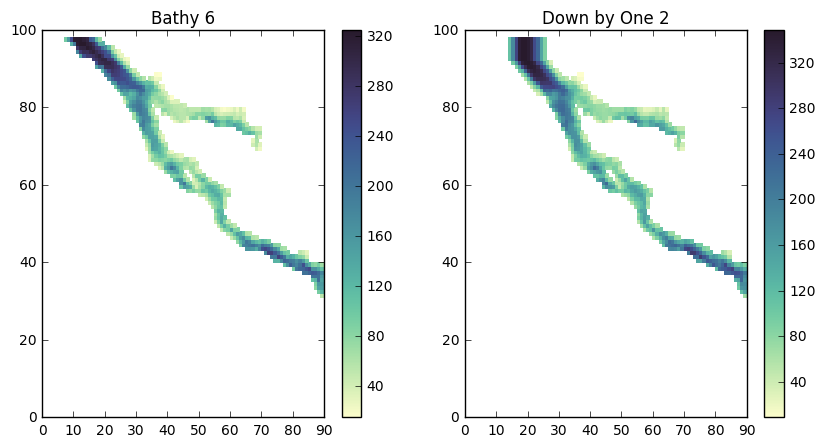

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
mesh = axs[0].pcolormesh(bathy[800:, 30:120], cmap=cm.deep)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_title('Bathy 6')
print (old_depth[:].shape)
mesh = axs[1].pcolormesh(old_depth[800:, 30:120], cmap=cm.deep)
fig.colorbar(mesh, ax=axs[1])
axs[1].set_title('Down by One 2')

In [32]:
floor = np.empty_like(depths)
ceil = np.empty_like(depths)
ceil[0] = 0.
floor[0] = 2*depths[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depths[k] -floor[k-1]

In [38]:
S = np.empty_like(old_S)
T = np.empty_like(old_T)
#for every cell with top of cell depth < bathymetry, use old TS, if old TS=0, find closest point and use that.
for k in range(40):
    print (k)
    for j in range(398):
        for i in range(898):
            if ceil[k] < bathy[i,j]:
                if old_S[k,i,j] > 0 and old_T[k,i,j]>0:
                    S[k,i,j] = old_S[k, i, j]
                    T[k,i,j] = old_T[k, i, j]
                else:
                    # closest neighbour thing
                    masked_array = np.ma.array(old_T[k], mask = old_T[k] == 0)
                    X, Y = geo_tools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat)
                    S[k, i, j] = old_S[k, X, Y]
                    T[k, i, j] = old_T[k, X, Y]
print ('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done


In [39]:
print (T.shape)

(40, 898, 398)


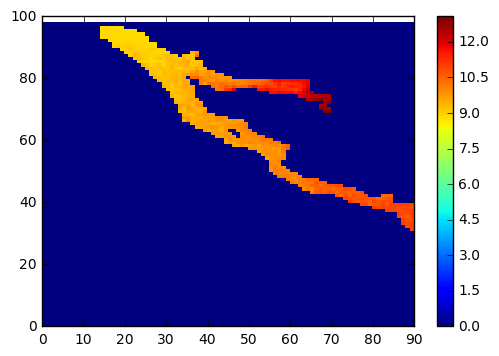

In [40]:
## temperature raw
plt.pcolormesh(T[3, 800:, 30:120])
plt.colorbar()

In [41]:
# build nc file
filename = '../../../NEMO-forcing/initial_strat/TS_11sep16.nc'
new_TS = nc.Dataset(filename, 'w')
nc_tools.init_dataset_attrs(
    new_TS, 
    title='Salinity Temperature Initial Conditions based on nowcast-green Sep 11, 2016 for bathymetry6', 
    notebook_name='TSforBathy6fromDB1', 
    nc_filepath=filename,)
new_TS.createDimension('y', 898)
new_TS.createDimension('x', 398)
new_TS.createDimension('deptht',size = len(depths))
new_TS.createDimension('time_counter', None)
nc_tools.show_dimensions(new_TS)
# show variables
nav_lat = new_TS.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat = lat
nav_lon = new_TS.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon = lon
deptht = new_TS.createVariable('deptht', 'float32', ('deptht'))
deptht.long_name = 'Depth'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))##minimum depth 4m
deptht = depths
time_counter = new_TS.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.long_name = 'Time axis'
vosaline = new_TS.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','y','x'))
vosaline.units = 'g/kg'
vosaline.long_name = 'Reference Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'SalishSea6, north extended Fraser'
vosaline[0] = S
votemper = new_TS.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','y','x'))
votemper.units = 'degC'
votemper.long_name = 'Conservative Temperature' 
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper[0] = T
new_TS.history = """[2017-01-31] Created"""

file format: NETCDF4
Conventions: CF-1.6
title: Salinity Temperature Initial Conditions based on nowcast-green Sep 11, 2016 for bathymetry6
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/TSforBathy6fromDB1.ipynb
references: https://bitbucket.org/salishsea/nemo-forcing/src/tip/initial_strat/TS_11sep16.nc
history: [2017-01-31 18:00:40] Created netCDF4 zlib=True dataset.
comment: 
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0



In [42]:
new_TS.close()